1. DATA PREPROCESSING & EXPLORATORY DATA ANALYSIS

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sentence_transformers import SentenceTransformer
import faiss
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.llms import HuggingFaceHub
from langchain.chains import RetrievalQA
from langchain.docstore.document import Document
import os
from dotenv import load_dotenv
load_dotenv()  # Loads variables from .env file

True

In [4]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
import os

In [5]:
# list all the PDFs in the PDF Folder
os.listdir('PDF Folder')

['AI business model innovation.pdf',
 'BI approaches.pdf',
 'Time-Series-Data-Prediction-using-IoT-and-Machine-Le_2020_Procedia-Computer-.pdf',
 'Walmarts sales data analysis.pdf']

In [6]:
pdf_folder = 'PDF Folder'
documents = []
for file in os.listdir(pdf_folder):
    if file.endswith('.pdf'):
        loader = PyPDFLoader(os.path.join(pdf_folder, file))
        documents.extend(loader.load())

In [7]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
texts = text_splitter.split_documents(documents)

print(f"Total number of text chunks: {len(texts)}")
print("First chunk example:")
print(texts[1].page_content[:500] + "...")

Total number of text chunks: 301
First chunk example:
ARTICLE INFO  
Keywords: 
Business model innovation 
Artificial intelligence 
Value proposition 
AI-driven BMI 
Systematic literature review 
ABSTRACT  
Recent years have seen a surge in research on artificial intelligence (AI)-driven business model innovation (BMI), 
reflecting its profound impact across industries. However, the field ’ s current state remains fragmented due to 
varied conceptual lenses and units of analysis. Existing literature predominantly emphasizes the technological 
aspec...


In [8]:
import pickle
with open('processed_texts.pkl', 'wb') as f:
    pickle.dump(texts, f)
print("Processed texts saved to 'processed_texts.pkl'")

Processed texts saved to 'processed_texts.pkl'


In [9]:
# Loading the dataset

In [10]:
df = pd.read_csv('sales_data.csv')

In [11]:
df['Date'] = pd.to_datetime(df['Date'])  # Ensure Date is datetime and parsed

In [12]:
df.head() # shows first 5 rows

,Date,Product,Region,Sales,Customer_Age,Customer_Gender,Customer_Satisfaction
0,2022-01-01,Widget C,South,786,26,Male,2.874407
1,2022-01-02,Widget D,East,850,29,Male,3.365205
2,2022-01-03,Widget A,North,871,40,Female,4.547364
3,2022-01-04,Widget C,South,464,31,Male,4.555420
4,2022-01-05,Widget C,South,262,50,Female,3.982935


In [13]:
df.describe(include='all') # statistical summary of dataset

C:\Users\hp\AppData\Local\Temp\ipykernel_29460\1701153271.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all') # statistical summary of dataset


,Date,Product,Region,Sales,Customer_Age,Customer_Gender,Customer_Satisfaction
count,2500,2500,2500,2500.000000,2500.000000,2500,2500.000000
unique,2500,4,4,NaN,NaN,2,NaN
top,2022-01-01 00:00:00,Widget A,West,NaN,NaN,Female,NaN
freq,1,656,644,NaN,NaN,1256,NaN
first,2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,2028-11-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,553.288000,43.332800,NaN,3.025869
std,NaN,NaN,NaN,260.101758,14.846758,NaN,1.156981
min,NaN,NaN,NaN,100.000000,18.000000,NaN,1.005422
25%,NaN,NaN,NaN,324.750000,31.000000,NaN,2.056014


In [14]:
df.info() # view dataset summary

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   2500 non-null   datetime64[ns]
 1   Product                2500 non-null   object        
 2   Region                 2500 non-null   object        
 3   Sales                  2500 non-null   int64         
 4   Customer_Age           2500 non-null   int64         
 5   Customer_Gender        2500 non-null   object        
 6   Customer_Satisfaction  2500 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 136.8+ KB


In [15]:
# Distribution of numerical and categorical features
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=[object]).columns.tolist()

print("\n🔢 Numerical Columns:", numerical_cols)
print("\n🔤 Categorical Columns:", categorical_cols)


🔢 Numerical Columns: ['Sales', 'Customer_Age', 'Customer_Satisfaction']

🔤 Categorical Columns: ['Product', 'Region', 'Customer_Gender']


In [16]:
# Unique values in key fields
for col in ['Product', 'Region', 'Customer_Gender']:
    print(f"\n✅ Unique values in {col}: {df[col].unique()}")


✅ Unique values in Product: ['Widget C' 'Widget D' 'Widget A' 'Widget B']

✅ Unique values in Region: ['South' 'East' 'North' 'West']

✅ Unique values in Customer_Gender: ['Male' 'Female']


In [17]:
for col in df.columns:
    print(f"{col} → {df[col].nunique()} unique values")
    print(df[col].unique()[:5], "\n")

Date → 2500 unique values
['2022-01-01T00:00:00.000000000' '2022-01-02T00:00:00.000000000'
 '2022-01-03T00:00:00.000000000' '2022-01-04T00:00:00.000000000'
 '2022-01-05T00:00:00.000000000'] 

Product → 4 unique values
['Widget C' 'Widget D' 'Widget A' 'Widget B'] 

Region → 4 unique values
['South' 'East' 'North' 'West'] 

Sales → 836 unique values
[786 850 871 464 262] 

Customer_Age → 52 unique values
[26 29 40 31 50] 

Customer_Gender → 2 unique values
['Male' 'Female'] 

Customer_Satisfaction → 2500 unique values
[2.87440724 3.3652046  4.54736361 4.55542039 3.98293493] 



In [18]:
# Regional sales
sales_region = df.groupby('Region')['Sales'].sum().sort_values(ascending=False)

In [19]:
print("\nSales by Region:\n", sales_region)


Sales by Region:
 Region
West     361383
North    353025
South    348516
East     320296
Name: Sales, dtype: int64


In [20]:
# Sales Performance by Time Period ===
monthly_sales = df.set_index('Date')['Sales'].resample('M').sum().reset_index()
monthly_sales['Month'] = monthly_sales['Date'].dt.strftime('%B %Y')
print("Monthly Sales:")
print(monthly_sales.head())

Monthly Sales:
        Date  Sales          Month
0 2022-01-31  18470   January 2022
1 2022-02-28  15208  February 2022
2 2022-03-31  14590     March 2022
3 2022-04-30  13376     April 2022
4 2022-05-31  16215       May 2022


In [21]:
# Total sales
sales_total = df['Sales'].sum()

In [22]:
print("Total Sales:", sales_total)

Total Sales: 1383220


In [23]:
# Product and Regional Analysis
product_sales = df.groupby('Product')['Sales'].agg(['sum', 'mean', 'median', 'std']).reset_index()
region_sales = df.groupby('Region')['Sales'].agg(['sum', 'mean', 'median', 'std']).reset_index()
print("\nProduct Sales Summary:")
print(product_sales)


Product Sales Summary:
    Product     sum        mean  median         std
0  Widget A  375235  572.004573   582.0  257.582101
1  Widget B  346062  565.460784   570.0  260.212912
2  Widget C  335069  540.433871   541.5  263.983086
3  Widget D  326854  534.075163   536.0  257.299193


In [24]:
# Top selling products
top_products = df.groupby('Product')['Sales'].sum().sort_values(ascending=False).head(5)

In [25]:
print("\nTop Products:\n", top_products)


Top Products:
 Product
Widget A    375235
Widget B    346062
Widget C    335069
Widget D    326854
Name: Sales, dtype: int64


In [26]:
# Customer Segmentation by Demographics (Age Group + Gender)
bins = [0, 18, 25, 35, 45, 60, 100]
labels = ['<18', '18-25', '26-35', '36-45', '46-60', '60+']
df['Age_Group'] = pd.cut(df['Customer_Age'], bins=bins, labels=labels, right=False)

demographic_sales = df.groupby(['Age_Group', 'Customer_Gender'])['Sales'] \
                      .agg(['sum', 'mean', 'median', 'std']).reset_index()
print("\nDemographic Sales Summary:")
print(demographic_sales)


Demographic Sales Summary:
   Age_Group Customer_Gender     sum        mean  median         std
0        <18          Female       0         NaN     NaN         NaN
1        <18            Male       0         NaN     NaN         NaN
2      18-25          Female   96082  558.616279   578.5  256.067547
3      18-25            Male   92829  583.830189   669.0  272.600700
4      26-35          Female  135953  566.470833   551.0  259.700357
5      26-35            Male  133731  541.421053   533.0  263.219330
6      36-45          Female  136802  538.590551   550.5  259.963356
7      36-45            Male  144448  541.003745   554.0  248.689324
8      46-60          Female  198486  565.487179   555.0  251.606255
9      46-60            Male  181186  542.473054   532.5  256.247108
10       60+          Female  134728  563.715481   566.0  267.351173
11       60+            Male  128975  544.198312   548.0  275.426170


In [27]:
# Overall Statistical Measures 
overall_stats = df['Sales'].agg(['mean', 'median', 'std', 'min', 'max', 'count'])
print("\nOverall Stats:")
print(overall_stats)


Overall Stats:
mean       553.288000
median     552.500000
std        260.101758
min        100.000000
max        999.000000
count     2500.000000
Name: Sales, dtype: float64


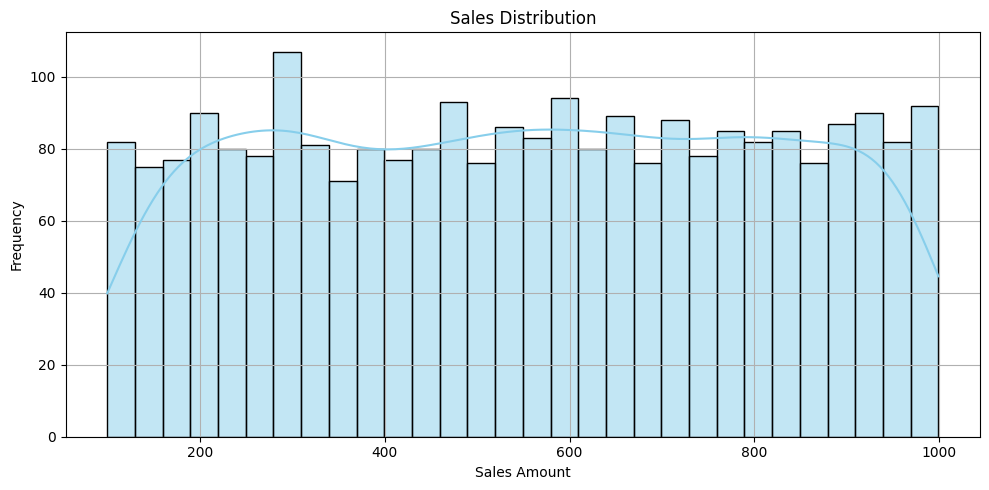

In [28]:
# Visual overview of sales distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['Sales'], bins=30, kde=True, color='skyblue')
plt.title("Sales Distribution")
plt.xlabel("Sales Amount")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

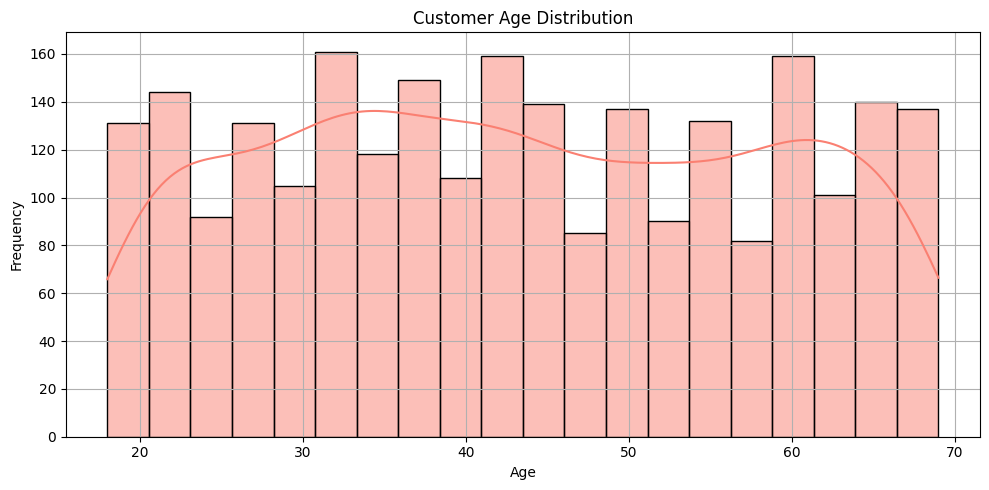

In [29]:
# Visual distribution of Customer Age
plt.figure(figsize=(10, 5))
sns.histplot(df['Customer_Age'], bins=20, kde=True, color='salmon')
plt.title("Customer Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

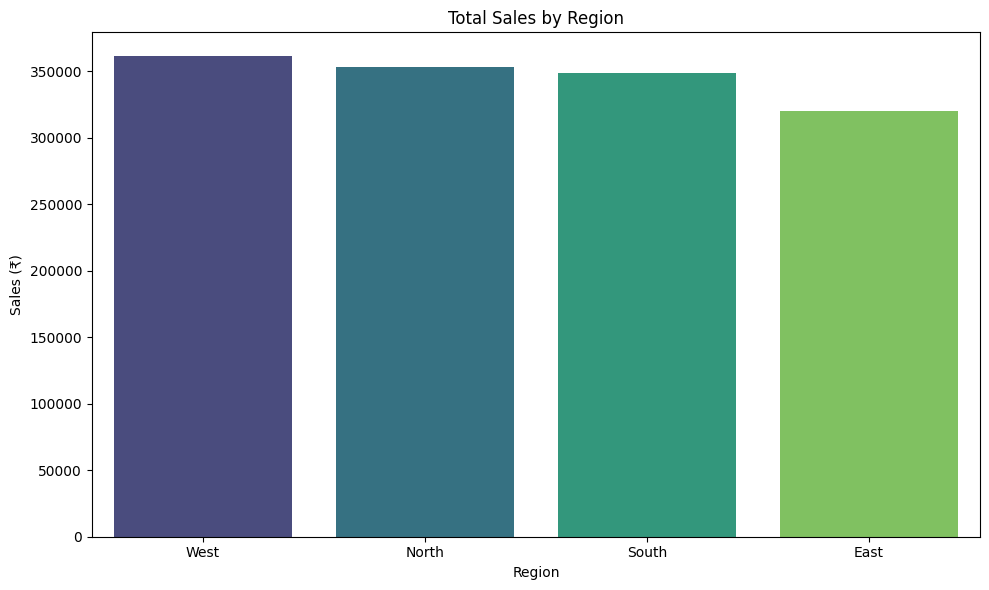

In [30]:
# Sales by region
# Sales by region
region_sales = df.groupby('Region')['Sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=region_sales.index, y=region_sales.values, palette="viridis")
plt.title("Total Sales by Region")
plt.ylabel("Sales (₹)")
plt.xlabel("Region")
plt.tight_layout()
plt.show()

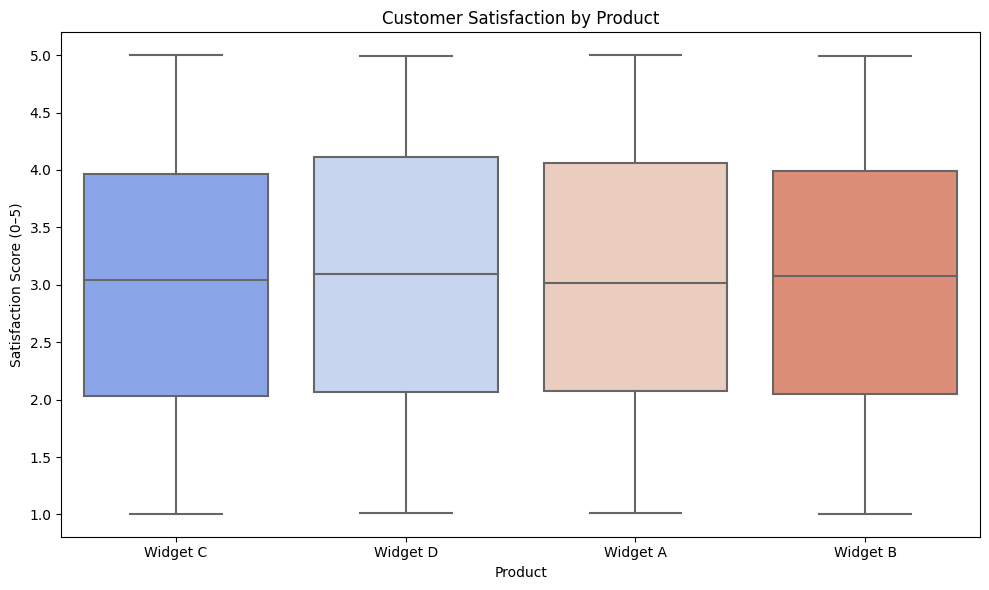

In [31]:
# Customer Satisfaction per Product
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='Product', y='Customer_Satisfaction', palette="coolwarm")
plt.title("Customer Satisfaction by Product")
plt.ylabel("Satisfaction Score (0–5)")
plt.xlabel("Product")
plt.tight_layout()
plt.show()

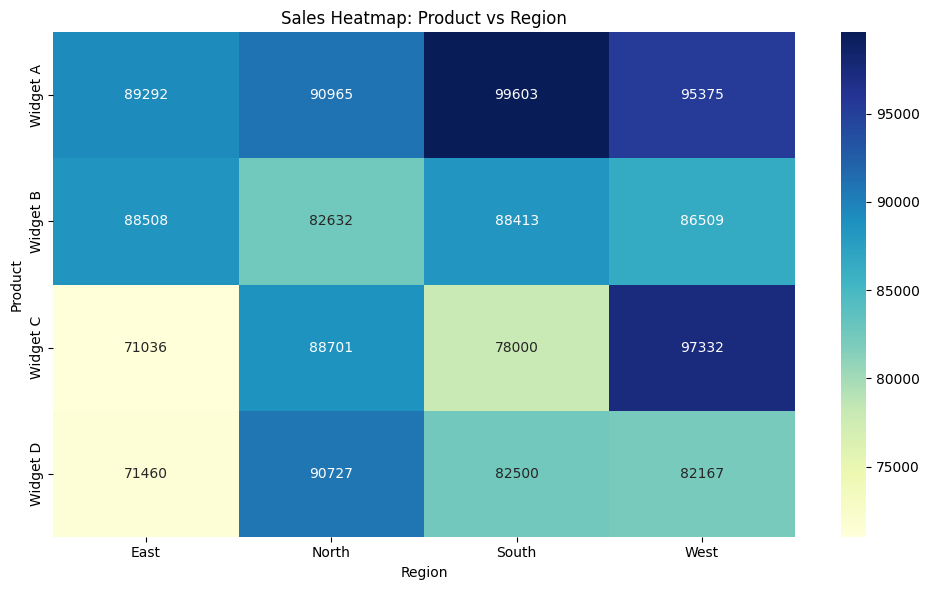

In [32]:
# Heatmap: Product vs Region Sales
pivot = df.pivot_table(index='Product', columns='Region', values='Sales', aggfunc='sum')

plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap='YlGnBu')
plt.title("Sales Heatmap: Product vs Region")
plt.ylabel("Product")
plt.xlabel("Region")
plt.tight_layout()
plt.show()


2. Advanced Data Summary - Trends and Segments

In [34]:
# Sales Performance by Time Period (Monthly)
monthly_sales = df.set_index('Date')['Sales'].resample('M').sum().reset_index()
monthly_sales['Month'] = monthly_sales['Date'].dt.strftime('%B %Y')
print("\n📈 Monthly Sales Performance:")
print(monthly_sales[['Month', 'Sales']].head())


📈 Monthly Sales Performance:
           Month  Sales
0   January 2022  18470
1  February 2022  15208
2     March 2022  14590
3     April 2022  13376
4       May 2022  16215


In [35]:
# Product-wise Summary
product_sales = df.groupby('Product')['Sales'].agg(['sum', 'mean', 'median', 'std']).reset_index()
print("\n📦 Product-wise Sales Summary:")
print(product_sales)


📦 Product-wise Sales Summary:
    Product     sum        mean  median         std
0  Widget A  375235  572.004573   582.0  257.582101
1  Widget B  346062  565.460784   570.0  260.212912
2  Widget C  335069  540.433871   541.5  263.983086
3  Widget D  326854  534.075163   536.0  257.299193


In [36]:
# Region-wise Summary
region_sales = df.groupby('Region')['Sales'].agg(['sum', 'mean', 'median', 'std']).reset_index()
print("\n🌍 Region-wise Sales Summary:")
print(region_sales)


🌍 Region-wise Sales Summary:
  Region     sum        mean  median         std
0   East  320296  543.796265   544.0  255.647163
1  North  353025  552.464789   551.0  258.679432
2  South  348516  554.961783   552.0  260.623468
3   West  361383  561.153727   571.0  265.308939


In [37]:
# Customer Segmentation by Demographics
# Bin customer ages into defined segments
bins = [0, 18, 25, 35, 45, 60, 100]
labels = ['<18', '18-25', '26-35', '36-45', '46-60', '60+']
df['Age_Group'] = pd.cut(df['Customer_Age'], bins=bins, labels=labels, right=False)

In [38]:
# Group by Age Group + Gender
demographic_sales = df.groupby(['Age_Group', 'Customer_Gender'])['Sales'].agg(['sum', 'mean', 'median', 'std']).reset_index()
print("\n👥 Demographic Sales Summary:")
print(demographic_sales)


👥 Demographic Sales Summary:
   Age_Group Customer_Gender     sum        mean  median         std
0        <18          Female       0         NaN     NaN         NaN
1        <18            Male       0         NaN     NaN         NaN
2      18-25          Female   96082  558.616279   578.5  256.067547
3      18-25            Male   92829  583.830189   669.0  272.600700
4      26-35          Female  135953  566.470833   551.0  259.700357
5      26-35            Male  133731  541.421053   533.0  263.219330
6      36-45          Female  136802  538.590551   550.5  259.963356
7      36-45            Male  144448  541.003745   554.0  248.689324
8      46-60          Female  198486  565.487179   555.0  251.606255
9      46-60            Male  181186  542.473054   532.5  256.247108
10       60+          Female  134728  563.715481   566.0  267.351173
11       60+            Male  128975  544.198312   548.0  275.426170


In [39]:
# Overall Descriptive Statistics
overall_stats = df['Sales'].agg(['mean', 'median', 'std', 'min', 'max', 'count'])
print("\n📐 Overall Sales Statistics:")
print(overall_stats)



📐 Overall Sales Statistics:
mean       553.288000
median     552.500000
std        260.101758
min        100.000000
max        999.000000
count     2500.000000
Name: Sales, dtype: float64


In [40]:
def generate_advanced_data_summary(df):
    
    # Sales Analysis
    total_sales = df['Sales'].sum()
    avg_sale = df['Sales'].mean()
    median_sale = df['Sales'].median()
    sales_std = df['Sales'].std()

    # Time-based Analysis
    df['Month'] = df['Date'].dt.to_period('M')
    monthly_sales = df.groupby('Month', observed=False)['Sales'].sum().sort_values(ascending=False)
    best_month = monthly_sales.index[0]
    worst_month = monthly_sales.index[-1]

    # Product Analysis
    product_sales = df.groupby('Product', observed=False)['Sales'].agg(['sum', 'count', 'mean'])
    top_product = product_sales['sum'].idxmax()
    most_sold_product = product_sales['count'].idxmax()

    # Regional Analysis
    region_sales = df.groupby('Region', observed=False)['Sales'].sum().sort_values(ascending=False)
    best_region = region_sales.index[0]
    worst_region = region_sales.index[-1]

    # Customer Analysis
    avg_satisfaction = df['Customer_Satisfaction'].mean()
    satisfaction_std = df['Customer_Satisfaction'].std()

    age_bins = [0, 25, 35, 45, 55, 100]
    age_labels = ['18-25', '26-35', '36-45', '46-55', '55+']
    df['Age_Group'] = pd.cut(df['Customer_Age'], bins=age_bins, labels=age_labels, right=False)
    age_group_sales = df.groupby('Age_Group', observed=False)['Sales'].mean().sort_values(ascending=False)
    best_age_group = age_group_sales.index[0]

    # Gender Analysis
    gender_sales = df.groupby('Customer_Gender', observed=False)['Sales'].mean()

    summary = f"""
    Advanced Sales Data Summary:

    Overall Sales Metrics:
    - Total Sales: ${total_sales:,.2f}
    - Average Sale: ${avg_sale:.2f}
    - Median Sale: ${median_sale:.2f}
    - Sales Standard Deviation: ${sales_std:.2f}

    Time-based Analysis:
    - Best Performing Month: {best_month}
    - Worst Performing Month: {worst_month}

    Product Analysis:
    - Top Selling Product (by value): {top_product}
    - Most Frequently Sold Product: {most_sold_product}

    Regional Performance:
    - Best Performing Region: {best_region}
    - Worst Performing Region: {worst_region}

    Customer Insights:
    - Average Customer Satisfaction: {avg_satisfaction:.2f}/5
    - Customer Satisfaction Standard Deviation: {satisfaction_std:.2f}
    - Best Performing Age Group: {best_age_group}
    - Gender-based Average Sales: Male=${gender_sales['Male']:.2f}, Female=${gender_sales['Female']:.2f}


    Key Observations:
    1. The sales data shows significant variability with a standard deviation of ${sales_std:.2f}.
    2. The {best_age_group} age group shows the highest average sales.
    3. Regional performance varies significantly, with {best_region} outperforming {worst_region}.
    4. The most valuable product ({top_product}) differs from the most frequently sold product ({most_sold_product}), suggesting potential for targeted marketing strategies.
    """

    return summary

In [41]:
advanced_summary = generate_advanced_data_summary(df)

3: STRUCTURE INSIGHTS INTO TEXT CHUNKS FOR RAG

In [43]:
# Age Group and Gender Insights
# Purpose: Convert key data summaries into natural language strings

structured_knowledge = []  # ← Define the list before appending anything
for _, row in demographic_sales.iterrows():
    age = row['Age_Group']
    gender = row['Customer_Gender']
    total = row['sum']
    if not np.isnan(total) and total > 0:
        structured_knowledge.append(
            f"{gender} customers in age group {age} purchased products worth ₹{int(total):,}."
        )

In [44]:
# Region Sales Insights
for _, row in region_sales.iterrows():
    structured_knowledge.append(
        f"Region {row['Region']} had total sales of ₹{int(row['sum']):,}, with an average sale of ₹{int(row['mean']):,}."
    )


In [45]:
# Product Sales Insights
for _, row in product_sales.iterrows():
    structured_knowledge.append(
        f"{row['Product']} recorded total sales of ₹{int(row['sum']):,}, with median ₹{int(row['median']):,} and std deviation ₹{int(row['std']):,}."
    )


In [46]:

# Monthly Sales Performance Insights
for _, row in monthly_sales.iterrows():
    structured_knowledge.append(
        f"In {row['Month']}, total sales were ₹{int(row['Sales']):,}."
    )


In [47]:

# Preview of structured insights
print("\n🧾 Structured Knowledge Chunks:")
for insight in structured_knowledge[:5]:
    print("•", insight)


🧾 Structured Knowledge Chunks:
• Female customers in age group 18-25 purchased products worth ₹96,082.
• Male customers in age group 18-25 purchased products worth ₹92,829.
• Female customers in age group 26-35 purchased products worth ₹135,953.
• Male customers in age group 26-35 purchased products worth ₹133,731.
• Female customers in age group 36-45 purchased products worth ₹136,802.


In [48]:
# PDF Processing Block
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
import os

pdf_folder_path = "PDF Folder"
all_docs = []

for filename in os.listdir(pdf_folder_path):
    if filename.endswith(".pdf"):
        loader = PyPDFLoader(os.path.join(pdf_folder_path, filename))
        pages = loader.load()
        splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
        chunks = splitter.split_documents(pages)
        all_docs.extend(chunks)

print(f"✅ Loaded {len(all_docs)} PDF chunks.")

# Combine PDFs with structured insights
documents = structured_knowledge + all_docs


✅ Loaded 301 PDF chunks.



4. EMBEDDING KNOWLEDGE BASE WITH FAISS FOR RETRIEVAL


Install/Import Required Libraries 

In [51]:
from langchain.docstore.document import Document

# Final filtered list — always end up with plain Document objects
final_documents = []

for item in documents:
    if isinstance(item, Document):
        final_documents.append(item)
    elif isinstance(item, str):
        final_documents.append(Document(page_content=item))
    elif isinstance(item, dict) and "page_content" in item:
        final_documents.append(Document(page_content=item["page_content"]))
    else:
        raise ValueError(f"Unrecognized item in documents: {type(item)}")


embedder = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vectorstore = FAISS.from_documents(final_documents, embedder)


C:\Users\hp\AppData\Local\Temp\ipykernel_29460\2892045461.py:17: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedder = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


In [52]:
from langchain.prompts import PromptTemplate
from langchain.chains.qa_with_sources import load_qa_with_sources_chain

# This prompt must use the variable "summaries"
prompt_template = PromptTemplate(
    input_variables=["summaries", "question"],
    template="""
You are a smart AI business analyst. Use the provided summaries to answer the user's query.

Summaries:
{summaries}

Question:
{question}

Answer:"""
)

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from langchain_community.llms import HuggingFacePipeline

model_id = "google/flan-t5-base"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

# Create pipeline
hf_pipeline = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=512,
    truncation=True,
    do_sample=False
)

# Wrap in LangChain LLM interface
llm = HuggingFacePipeline(pipeline=hf_pipeline)

# Create a chain using that prompt
qa_chain = load_qa_with_sources_chain(llm, chain_type="stuff", prompt=prompt_template)


Device set to use cpu
C:\Users\hp\AppData\Local\Temp\ipykernel_29460\1194147743.py:39: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=hf_pipeline)
C:\Users\hp\AppData\Local\Temp\ipykernel_29460\1194147743.py:42: LangChainDeprecationWarning: This function is deprecated. Refer to this guide on retrieval and question answering with sources: https://python.langchain.com/docs/how_to/qa_sources/
See also the following migration guides for replacements based on `chain_type`:
stuff: https://python.langchain.com/docs/versions/migrating_chains/stuff_docs_chain
map_reduce: https://python.langchain.com/docs/versions/migrating_chains/m

In [68]:
input_documents = texts[:5]

question = "What was the sales trend in Q2?"
response = qa_chain.invoke({
    "input_documents": input_documents,
    "question": question
})

print("Q:", question)
print("Answer:", response["output_text"])


Q: What was the sales trend in Q2?
Answer: A systematic review and research agenda on AI-driven business model innovation: A systematic review and research agenda


5. LLM AND RETRIEVAL QA SETUP 

Load a Free LLM from HuggingFace

In [72]:
from langchain.chains import RetrievalQA
from langchain_community.llms import HuggingFacePipeline
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline


In [74]:
from langchain.chains.qa_with_sources import load_qa_with_sources_chain
qa_chain = load_qa_with_sources_chain(llm, chain_type="stuff", prompt=prompt_template)


Build the FAISS Retriever (reuse existing vectorstore)

In [77]:
# Choose a good Q&A model
model_id = "google/flan-t5-base"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

# Build a text2text generation pipeline
hf_pipeline = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=512,
    truncation=True,         # ✨ THIS LINE
    do_sample=False
)


# Wrap it in LangChain LLM class
llm = HuggingFacePipeline(pipeline=hf_pipeline)


Device set to use cpu


Create the RetrievalQA Chain

In [80]:
retriever = vectorstore.as_retriever()


In [82]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    return_source_documents=True  # Optional, for traceability
)


In [84]:
from langchain.evaluation.qa import QAEvalChain

# Step 1: Define input QA examples
examples = [
    {
        "query": "Which region had the highest sales?",
        "answer": "The North region recorded the highest total sales overall, especially in Q2."
    },
    {
        "query": "Which product had the best customer satisfaction?",
        "answer": "Product A had the highest satisfaction rating, particularly in the South zone."
    }
]


# Step 2: Use your QA chain to generate model responses
predictions = []
for ex in examples:
    result = qa_chain.invoke({"query": ex["query"]})["result"]
    predictions.append({"query": ex["query"], "result": result})

# Step 3: Run evaluation
eval_chain = QAEvalChain.from_llm(llm)
graded_outputs = eval_chain.evaluate(examples, predictions)

# Step 4: Print results
for i, grade in enumerate(graded_outputs):
    print(f"\n❓ Q: {examples[i]['query']}")
    print(f"🤖 Model's Answer: {predictions[i]['result']}")
    print(f"✅ Ground Truth: {examples[i]['answer']}")
    print(f"🧠 Evaluation by LLM: {grade.get('value', 'N/A')}")
    print(f"🧾 Explanation: {grade.get('reasoning', 'No reasoning available')}")




❓ Q: Which region had the highest sales?
🤖 Model's Answer: Region East
✅ Ground Truth: The North region recorded the highest total sales overall, especially in Q2.
🧠 Evaluation by LLM: N/A
🧾 Explanation: No reasoning available

❓ Q: Which product had the best customer satisfaction?
🤖 Model's Answer: Walmart’s sales data to make sense of the company as an overall retailer.
✅ Ground Truth: Product A had the highest satisfaction rating, particularly in the South zone.
🧠 Evaluation by LLM: N/A
🧾 Explanation: No reasoning available


In [86]:
query = "Which product had the highest sales in the South zone?"

result = qa_chain(query)

print("🧠 Insight from LLM:\n", result['result'])

# Optional: Display sources
for i, doc in enumerate(result['source_documents']):
    print(f"\n📄 Source {i+1}:\n", doc.page_content)


C:\Users\hp\AppData\Local\Temp\ipykernel_29460\91298580.py:3: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = qa_chain(query)


🧠 Insight from LLM:
 Helpful

📄 Source 1:
 Region South had total sales of ₹348,516, with an average sale of ₹554.

📄 Source 2:
 Region North had total sales of ₹353,025, with an average sale of ₹552.

📄 Source 3:
 Region East had total sales of ₹320,296, with an average sale of ₹543.

📄 Source 4:
 Region West had total sales of ₹361,383, with an average sale of ₹561.


6. MEMORY INTEGRATION

In [89]:
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain

# Add memory to track chat history
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

# Conversational RAG chain
conversational_chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=vectorstore.as_retriever(),
    memory=memory,
)

# Test multi-turn dialogue
response1 = conversational_chain({"question": "Which age group buys the most?"})
print("Q1:", response1["answer"])

response2 = conversational_chain({"question": "What products do they prefer, give their name?"})
print("Q2:", response2["answer"])

response3 = conversational_chain({"question": "What are top-selling products, show them category wise?"})
print("Q3:", response3["answer"])

C:\Users\hp\AppData\Local\Temp\ipykernel_29460\2612944351.py:5: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)


Q1: Male customers in age group 36-45
Q2: products worth 136,802.
Q3: 92,829. Male customers in age group 18-25 purchased products worth 92,829. Male customers in age group 36-45 purchased products worth 144,448. Female customers in age group 36-45 purchased products worth 136,802.


7. STREAMLIT UI INTEGRATION

In [92]:
# app.py
import streamlit as st

st.title("📊 InsightForge: AI Business Intelligence Assistant")

query = st.text_input("What are our top-selling products?")

if query:
    response = conversational_chain({"question": query})
    st.markdown("### 💡 Insight")
    st.success(response["answer"])


2025-06-12 23:56:13.073 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-12 23:56:13.217 
  command:

    streamlit run C:\Users\hp\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-06-12 23:56:13.219 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-12 23:56:13.220 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-12 23:56:13.220 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-12 23:56:13.221 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-12 23:56:13.222 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-12 23:56:13.223 Session state does not fun

2025-06-12 23:56:16.490 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-12 23:56:16.490 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-12 23:56:16.561 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-12 23:56:16.866 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-12 23:56:16.867 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

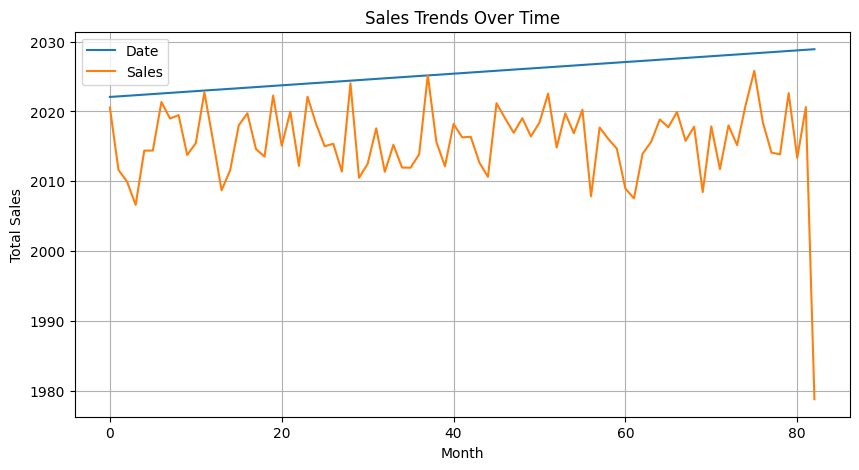

In [94]:
import streamlit as st
import matplotlib.pyplot as plt

st.subheader("📈 Sales Trends Over Time")

fig, ax = plt.subplots(figsize=(10, 5))
monthly_sales.plot(kind='line', ax=ax)
ax.set_title("Sales Trends Over Time")
ax.set_xlabel("Month")
ax.set_ylabel("Total Sales")
ax.grid(True)

st.pyplot(fig)


In [110]:
summary_text = generate_advanced_data_summary(df)  # Make sure this returns a STRING

st.subheader("📋 Advanced Data Summary")
st.text(summary_text)  

2025-06-13 00:28:33.992 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-13 00:28:33.992 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-13 00:28:33.993 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-13 00:28:33.995 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()